IMPORT NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("SALARY PREDICTION MODEL TRAINING")
print("="*60)

print("Loading dataset...")

SALARY PREDICTION MODEL TRAINING
Loading dataset...


LOAD DATASET

In [2]:
df = pd.read_csv('salary_prediction_data.csv')
df.columns = df.columns.str.strip()  # Clean column names

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())
print(f"\nData types:\n{df.dtypes}")

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)


Dataset shape: (1000, 7)
Columns: ['Education', 'Experience', 'Location', 'Job_Title', 'Age', 'Gender', 'Salary']

First 5 rows:
     Education  Experience  Location Job_Title  Age  Gender         Salary
0  High School           8     Urban   Manager   63    Male   84620.053665
1          PhD          11  Suburban  Director   59    Male  142591.255894
2     Bachelor          28  Suburban   Manager   61  Female   97800.255404
3  High School          29     Rural  Director   45    Male   96834.671282
4          PhD          25     Urban   Analyst   26  Female  132157.786175

Data types:
Education      object
Experience      int64
Location       object
Job_Title      object
Age             int64
Gender         object
Salary        float64
dtype: object

EXPLORATORY DATA ANALYSIS


Check for missing values

In [3]:
print(f"Missing values:\n{df.isnull().sum()}")

Missing values:
Education     0
Experience    0
Location      0
Job_Title     0
Age           0
Gender        0
Salary        0
dtype: int64


Display basic statistics

In [4]:
print(f"\nDataset Info:")
print(f"Total records: {len(df)}")
print(f"\nUnique values in categorical columns:")
for col in ['Education', 'Location', 'Job_Title', 'Gender']:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


Dataset Info:
Total records: 1000

Unique values in categorical columns:
Education: ['High School' 'PhD' 'Bachelor' 'Master']
Location: ['Urban' 'Suburban' 'Rural']
Job_Title: ['Manager' 'Director' 'Analyst' 'Engineer']
Gender: ['Male' 'Female']


Create correlation heatmap (only for numeric columns initially)

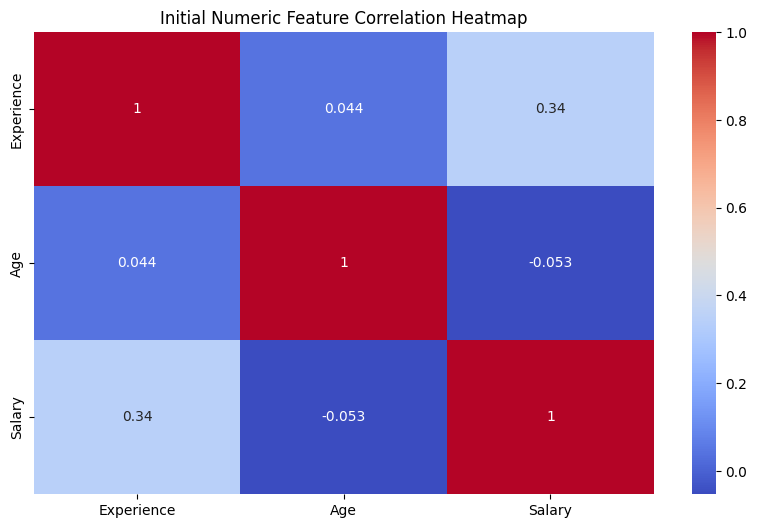


DATA PREPROCESSING


In [5]:
plt.figure(figsize=(10, 6))
numeric_cols = ['Experience', 'Age', 'Salary']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Initial Numeric Feature Correlation Heatmap")
plt.show()

print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

Remove missing values

In [6]:
original_size = len(df)
df = df.dropna()
print(f"Dataset shape after removing NaN: {df.shape}")
print(f"Removed {original_size - len(df)} rows with missing values")

Dataset shape after removing NaN: (1000, 7)
Removed 0 rows with missing values


Ensure exact encoding that matches your API

In [7]:
print("Encoding categorical variables to match API EXACTLY...")

Encoding categorical variables to match API EXACTLY...


Education encoding (matches your API exactly)

In [8]:
education_map = {"High School": 0, "Bachelor": 1, "Master": 2, "PhD": 3}
df['Education_encoded'] = df['Education'].map(education_map)

Location encoding (matches your API exactly)

In [9]:
location_map = {"Rural": 0, "Suburban": 1, "Urban": 2}
df['Location_encoded'] = df['Location'].map(location_map)

Job Title encoding (matches your API exactly)

In [10]:
job_title_map = {
    "Analyst": 0, "Consultant": 1, "Director": 2, 
    "Engineer": 3, "Manager": 4, "Specialist": 5
}
df['Job_Title_encoded'] = df['Job_Title'].map(job_title_map)

Gender encoding (matches your API exactly)

In [11]:
df['Gender_encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})

Verify encoding and handle unmapped values

In [12]:
print("Encoding verification and cleanup:")
encoding_pairs = [
    ('Education', 'Education_encoded', 1),  # Default to Bachelor
    ('Location', 'Location_encoded', 1),    # Default to Suburban
    ('Job_Title', 'Job_Title_encoded', 4),  # Default to Manager
    ('Gender', 'Gender_encoded', 1)         # Default to Male
]

for original_col, encoded_col, default_val in encoding_pairs:
    if original_col in df.columns:
        # Show unique values
        print(f"{original_col}: {sorted(df[original_col].unique())}")
        print(f"{encoded_col}: {sorted(df[encoded_col].dropna().unique())}")
        
        # Handle unmapped values
        unmapped_count = df[encoded_col].isnull().sum()
        if unmapped_count > 0:
            print(f"  WARNING: {unmapped_count} unmapped values found, setting to default ({default_val})")
            df[encoded_col] = df[encoded_col].fillna(default_val)
        
        print(f"  Final {encoded_col}: {sorted(df[encoded_col].unique())}")
        print()

Encoding verification and cleanup:
Education: ['Bachelor', 'High School', 'Master', 'PhD']
Education_encoded: [0, 1, 2, 3]
  Final Education_encoded: [0, 1, 2, 3]

Location: ['Rural', 'Suburban', 'Urban']
Location_encoded: [0, 1, 2]
  Final Location_encoded: [0, 1, 2]

Job_Title: ['Analyst', 'Director', 'Engineer', 'Manager']
Job_Title_encoded: [0, 2, 3, 4]
  Final Job_Title_encoded: [0, 2, 3, 4]

Gender: ['Female', 'Male']
Gender_encoded: [0, 1]
  Final Gender_encoded: [0, 1]



Define features in the EXACT order your API expects

In [13]:
print("Preparing features in API-compatible order...")
feature_columns = [
    'Education_encoded',    # Position 0: Education
    'Experience',          # Position 1: Experience  
    'Location_encoded',    # Position 2: Location
    'Job_Title_encoded',   # Position 3: Job_Title
    'Age',                 # Position 4: Age
    'Gender_encoded'       # Position 5: Gender
]


Preparing features in API-compatible order...


Verify all feature columns exist

In [14]:
missing_features = [col for col in feature_columns if col not in df.columns]
if missing_features:
    print(f"ERROR: Missing feature columns: {missing_features}")
    raise ValueError(f"Required columns not found: {missing_features}")

Create feature matrix X and target vector y

In [15]:
X = df[feature_columns].copy()
y = df['Salary'].copy()

print(f"Final Dataset Info:")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Feature columns (API order): {feature_columns}")

Final Dataset Info:
Feature matrix shape: (1000, 6)
Target vector shape: (1000,)
Feature columns (API order): ['Education_encoded', 'Experience', 'Location_encoded', 'Job_Title_encoded', 'Age', 'Gender_encoded']


Verify no missing values in final dataset

In [16]:
print(f"\nFinal data quality check:")
print(f"Features with NaN: {X.isnull().sum().sum()}")
print(f"Target with NaN: {y.isnull().sum()}")

if X.isnull().sum().sum() > 0:
    print("ERROR: Still have NaN values in features!")
    print(X.isnull().sum())
    raise ValueError("Cannot proceed with NaN values in features")


Final data quality check:
Features with NaN: 0
Target with NaN: 0


Display feature statistics

In [17]:
print("\nFeature Statistics:")
print(X.describe())


Feature Statistics:
       Education_encoded   Experience  Location_encoded  Job_Title_encoded  \
count        1000.000000  1000.000000       1000.000000        1000.000000   
mean            1.488000    14.771000          0.965000           2.201000   
std             1.123886     8.341111          0.808968           1.474711   
min             0.000000     1.000000          0.000000           0.000000   
25%             0.000000     7.000000          0.000000           0.000000   
50%             1.000000    15.000000          1.000000           2.000000   
75%             3.000000    22.000000          2.000000           3.000000   
max             3.000000    29.000000          2.000000           4.000000   

               Age  Gender_encoded  
count  1000.000000     1000.000000  
mean     42.377000        0.516000  
std      13.609412        0.499994  
min      20.000000        0.000000  
25%      30.000000        0.000000  
50%      43.000000        1.000000  
75%      55.00000

Enhanced correlation heatmap with all features

In [18]:
plt.figure(figsize=(12, 10))
correlation_data = X.copy()
correlation_data['Salary'] = y
correlation_matrix = correlation_data.corr()

<Figure size 1200x1000 with 0 Axes>

Rename columns for better display

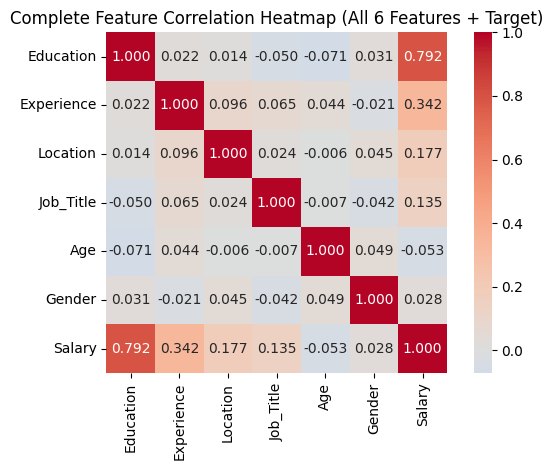


FEATURE SCALING


In [19]:
display_names = ['Education', 'Experience', 'Location', 'Job_Title', 'Age', 'Gender', 'Salary']
correlation_matrix.index = display_names
correlation_matrix.columns = display_names

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title("Complete Feature Correlation Heatmap (All 6 Features + Target)")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FEATURE SCALING")
print("="*50)

Create and fit the scaler

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original features shape: {X.shape}")
print(f"Scaled features shape: {X_scaled.shape}")
print(f"✅ Scaler configured for exactly {X_scaled.shape[1]} features")

Original features shape: (1000, 6)
Scaled features shape: (1000, 6)
✅ Scaler configured for exactly 6 features


Verify scaling worked

In [21]:
print(f"Scaling verification:")
print(f"  Mean of scaled features: {np.mean(X_scaled, axis=0).round(3)}")
print(f"  Std of scaled features: {np.std(X_scaled, axis=0).round(3)}")

print("\n" + "="*50)
print("TRAIN-TEST SPLIT")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set: Features {X_train.shape}, Target {y_train.shape}")
print(f"Test set: Features {X_test.shape}, Target {y_test.shape}")
print(f"Split ratio: {(len(y_train)/len(y))*100:.1f}% train, {(len(y_test)/len(y))*100:.1f}% test")

print("\n" + "="*50)
print("MODEL TRAINING & COMPARISON")
print("="*50)

Scaling verification:
  Mean of scaled features: [-0. -0.  0. -0. -0. -0.]
  Std of scaled features: [1. 1. 1. 1. 1. 1.]

TRAIN-TEST SPLIT
Training set: Features (800, 6), Target (800,)
Test set: Features (200, 6), Target (200,)
Split ratio: 80.0% train, 20.0% test

MODEL TRAINING & COMPARISON


Define models to compare

In [22]:
models = {
    'Linear Regression': LinearRegression(),
    'SGD Regressor': SGDRegressor(max_iter=2000, eta0=0.01, learning_rate='constant', random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10)
}

Store results

In [23]:
results = {}
errors = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Store results
        results[name] = {
            'model': model,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'predictions': y_pred_test
        }
        
        errors[name] = test_mse
        
        # Display results
        print(f"  ✅ Train MSE: {train_mse:.2f}")
        print(f"  ✅ Test MSE: {test_mse:.2f}")
        print(f"  ✅ Train R²: {train_r2:.4f}")
        print(f"  ✅ Test R²: {test_r2:.4f}")
        
        # Check for overfitting
        if train_r2 - test_r2 > 0.1:
            print(f"  ⚠️  Potential overfitting detected!")
        
    except Exception as e:
        print(f"  ❌ Error training {name}: {e}")

print("\n" + "="*50)
print("MODEL SELECTION")
print("="*50)

if not results:
    raise ValueError("No models trained successfully!")

Training models...

Training Linear Regression...
  ✅ Train MSE: 181094130.72
  ✅ Test MSE: 181267255.44
  ✅ Train R²: 0.7715
  ✅ Test R²: 0.7780

Training SGD Regressor...
  ✅ Train MSE: 182603593.84
  ✅ Test MSE: 189135368.14
  ✅ Train R²: 0.7696
  ✅ Test R²: 0.7684

Training Random Forest...
  ✅ Train MSE: 18830740.98
  ✅ Test MSE: 127287761.81
  ✅ Train R²: 0.9762
  ✅ Test R²: 0.8441
  ⚠️  Potential overfitting detected!

Training Decision Tree...
  ✅ Train MSE: 12248235.52
  ✅ Test MSE: 234155247.47
  ✅ Train R²: 0.9845
  ✅ Test R²: 0.7132
  ⚠️  Potential overfitting detected!

MODEL SELECTION


Select best model based on test R² score (higher is better)

In [24]:
best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['model']

print(f"🏆 Best Model: {best_model_name}")
print(f"   Test MSE: {results[best_model_name]['test_mse']:.2f}")
print(f"   Test R² Score: {results[best_model_name]['test_r2']:.4f}")
print(f"   Train R² Score: {results[best_model_name]['train_r2']:.4f}")

🏆 Best Model: Random Forest
   Test MSE: 127287761.81
   Test R² Score: 0.8441
   Train R² Score: 0.9762


Show all model comparison

In [25]:
print(f"\n📊 Model Comparison Summary:")
print(f"{'Model':<20} {'Test R²':<10} {'Test MSE':<12} {'Status'}")
print("-" * 50)
for name in results:
    r2 = results[name]['test_r2']
    mse = results[name]['test_mse']
    status = "🏆 BEST" if name == best_model_name else ""
    print(f"{name:<20} {r2:<10.4f} {mse:<12.2f} {status}")

print("\n" + "="*50)
print("SAVING MODELS")
print("="*50)


📊 Model Comparison Summary:
Model                Test R²    Test MSE     Status
--------------------------------------------------
Linear Regression    0.7780     181267255.44 
SGD Regressor        0.7684     189135368.14 
Random Forest        0.8441     127287761.81 🏆 BEST
Decision Tree        0.7132     234155247.47 

SAVING MODELS


Clean up and create model directory

In [26]:
if os.path.exists("model"):
    print("Cleaning existing model directory...")
    for file in os.listdir("model"):
        if file.endswith('.pkl'):
            os.remove(os.path.join("model", file))
            print(f"  Removed old {file}")
else:
    os.makedirs("model")
    print("Created model directory")

Cleaning existing model directory...
  Removed old model.pkl
  Removed old scaler.pkl


Save the best model

In [27]:
model_path = "model/model.pkl"
scaler_path = "model/scaler.pkl"

joblib.dump(best_model, model_path)
print(f"✅ Best model ({best_model_name}) saved to: {model_path}")

✅ Best model (Random Forest) saved to: model/model.pkl


Save the scaler

In [28]:
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler (6 features) saved to: {scaler_path}")

✅ Scaler (6 features) saved to: model/scaler.pkl


Save backup files

In [29]:
backup_model_path = "best_model.pkl"
backup_scaler_path = "scaler.pkl"

joblib.dump(best_model, backup_model_path)
joblib.dump(scaler, backup_scaler_path)
print(f"✅ Backup files created: {backup_model_path}, {backup_scaler_path}")

✅ Backup files created: best_model.pkl, scaler.pkl


Save metadata for debugging

In [30]:
metadata = {
    'best_model': best_model_name,
    'test_r2': results[best_model_name]['test_r2'],
    'test_mse': results[best_model_name]['test_mse'],
    'features': feature_columns,
    'n_features': len(feature_columns),
    'training_samples': len(y_train),
    'test_samples': len(y_test)
}

import json
with open("model/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Model metadata saved to: model/metadata.json")

print("\n" + "="*50)
print("MODEL VERIFICATION")
print("="*50)

try:
    # Load the saved model and scaler
    print("Loading saved files for verification...")
    loaded_model = joblib.load(model_path)
    loaded_scaler = joblib.load(scaler_path)
    
    # Test with multiple sample inputs to ensure robustness
    test_cases = [
        {
            'name': 'Sample 1 (Bachelor, Engineer)',
            'data': [1, 5.0, 2, 3, 30, 1],  # Bachelor, 5yr exp, Urban, Engineer, 30yr, Male
        },
        {
            'name': 'Sample 2 (Master, Manager)', 
            'data': [2, 8.0, 1, 4, 35, 0],  # Master, 8yr exp, Suburban, Manager, 35yr, Female
        },
        {
            'name': 'Sample 3 (PhD, Director)',
            'data': [3, 15.0, 2, 2, 45, 1], # PhD, 15yr exp, Urban, Director, 45yr, Male
        }
    ]
    
    print(f"Testing with {len(test_cases)} sample cases...")
    
    for i, test_case in enumerate(test_cases, 1):
        sample_input = np.array([test_case['data']])
        
        print(f"\n{i}. {test_case['name']}")
        print(f"   Input shape: {sample_input.shape}")
        print(f"   Input data: {sample_input[0]}")
        
        # Scale the input
        sample_scaled = loaded_scaler.transform(sample_input)
        print(f"   ✅ Scaling successful! Shape: {sample_scaled.shape}")
        
        # Make prediction
        sample_prediction = loaded_model.predict(sample_scaled)
        print(f"   ✅ Prediction: ${sample_prediction[0]:,.2f}")
    
    print(f"\n🎉 VERIFICATION COMPLETE - ALL TESTS PASSED!")
    print(f"   ✅ Model loads correctly")
    print(f"   ✅ Scaler expects exactly {sample_scaled.shape[1]} features")
    print(f"   ✅ All predictions work")
    print(f"   ✅ Ready for API integration!")
    
except Exception as e:
    print(f"❌ VERIFICATION FAILED: {e}")
    print("Check your file paths and model training")
    raise

print("\n" + "="*50)
print("VISUALIZATIONS")
print("="*50)

✅ Model metadata saved to: model/metadata.json

MODEL VERIFICATION
Loading saved files for verification...
Testing with 3 sample cases...

1. Sample 1 (Bachelor, Engineer)
   Input shape: (1, 6)
   Input data: [ 1.  5.  2.  3. 30.  1.]
   ✅ Scaling successful! Shape: (1, 6)
   ✅ Prediction: $89,687.00

2. Sample 2 (Master, Manager)
   Input shape: (1, 6)
   Input data: [ 2.  8.  1.  4. 35.  0.]
   ✅ Scaling successful! Shape: (1, 6)
   ✅ Prediction: $110,777.44

3. Sample 3 (PhD, Director)
   Input shape: (1, 6)
   Input data: [ 3. 15.  2.  2. 45.  1.]
   ✅ Scaling successful! Shape: (1, 6)
   ✅ Prediction: $151,327.75

🎉 VERIFICATION COMPLETE - ALL TESTS PASSED!
   ✅ Model loads correctly
   ✅ Scaler expects exactly 6 features
   ✅ All predictions work
   ✅ Ready for API integration!

VISUALIZATIONS


Create comprehensive visualizations

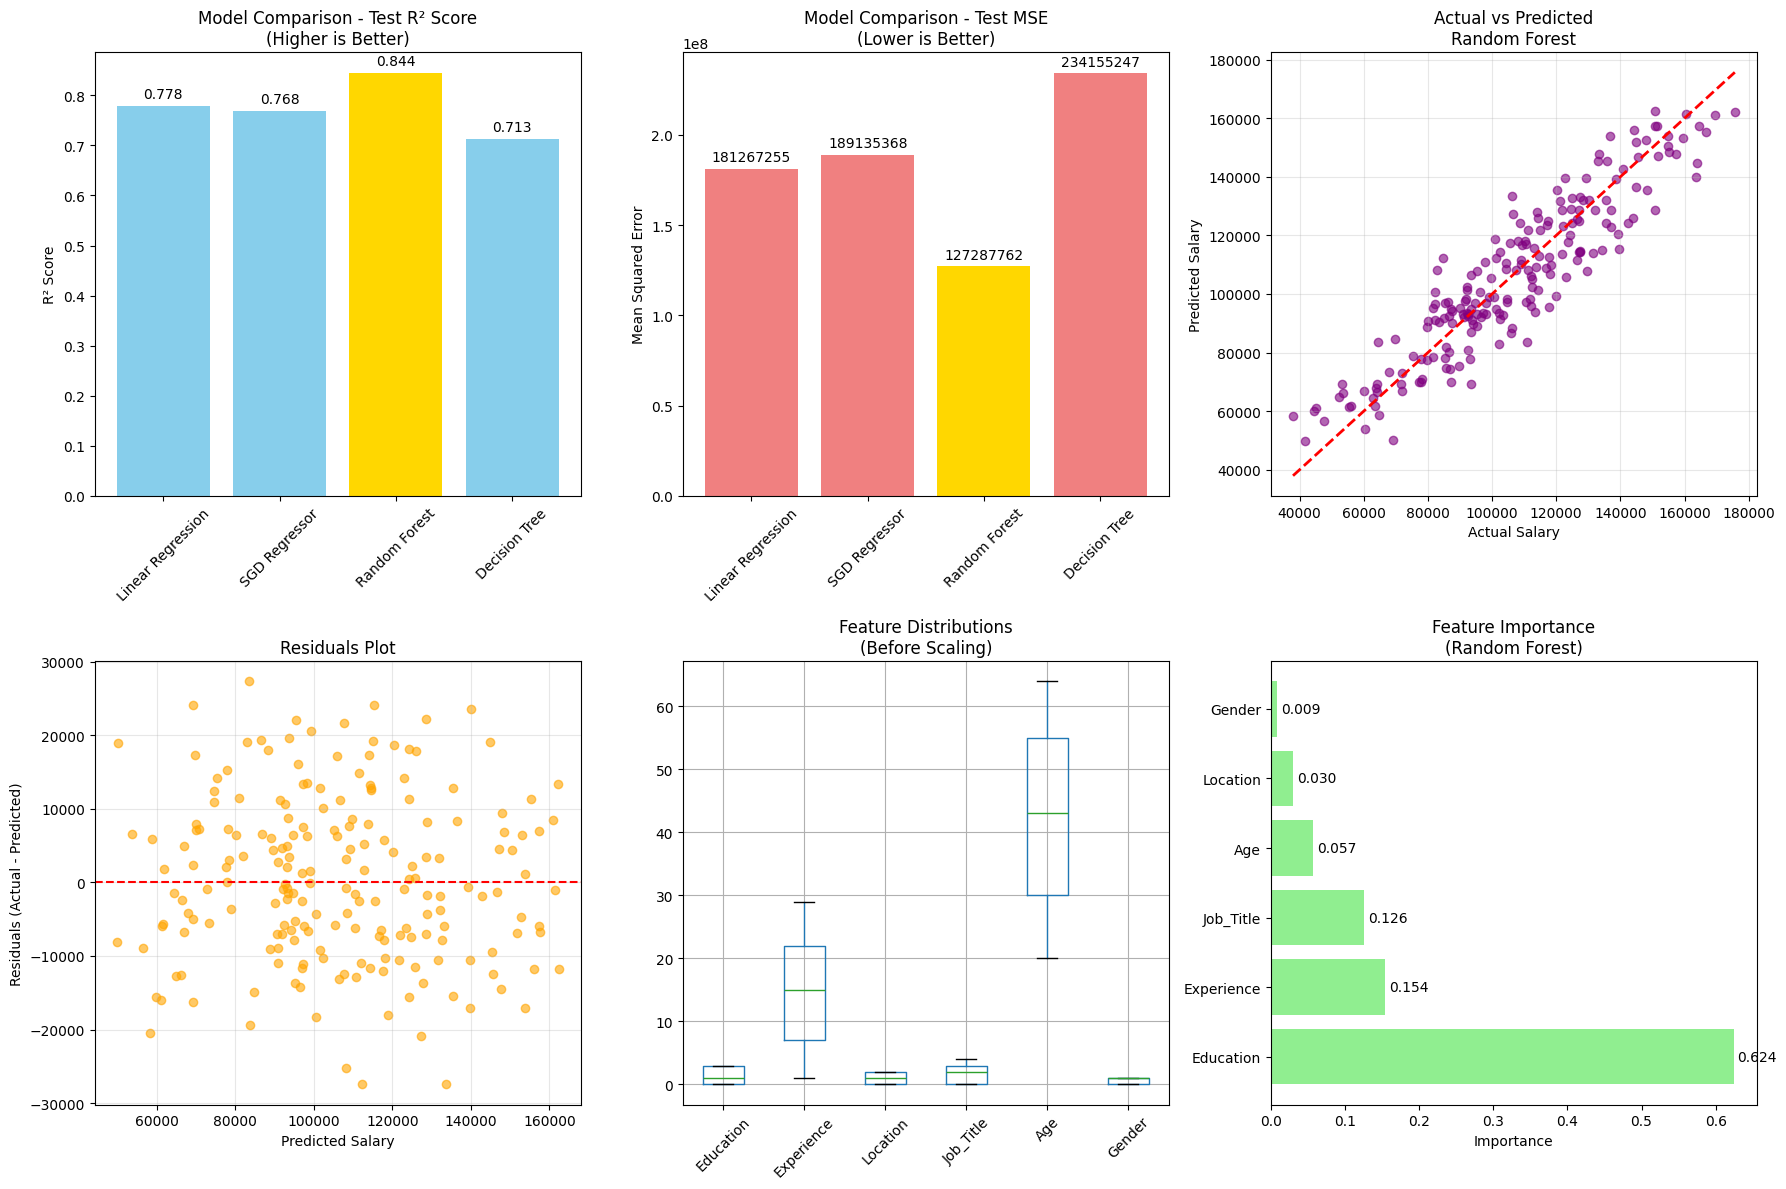

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model comparison - R² scores
ax1 = axes[0, 0]
model_names = list(results.keys())
r2_scores = [results[name]['test_r2'] for name in model_names]
bars1 = ax1.bar(model_names, r2_scores, color=['gold' if name == best_model_name else 'skyblue' for name in model_names])
ax1.set_title('Model Comparison - Test R² Score\n(Higher is Better)')
ax1.set_ylabel('R² Score')
ax1.tick_params(axis='x', rotation=45)
for bar, score in zip(bars1, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

# 2. Model comparison - MSE
ax2 = axes[0, 1]
mse_scores = [results[name]['test_mse'] for name in model_names]
bars2 = ax2.bar(model_names, mse_scores, color=['gold' if name == best_model_name else 'lightcoral' for name in model_names])
ax2.set_title('Model Comparison - Test MSE\n(Lower is Better)')
ax2.set_ylabel('Mean Squared Error')
ax2.tick_params(axis='x', rotation=45)
for bar, score in zip(bars2, mse_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_scores)*0.01, 
             f'{score:.0f}', ha='center', va='bottom')

# 3. Actual vs Predicted for best model
ax3 = axes[0, 2]
y_pred_best = results[best_model_name]['predictions']
ax3.scatter(y_test, y_pred_best, alpha=0.6, color='purple')
min_val, max_val = min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax3.set_xlabel('Actual Salary')
ax3.set_ylabel('Predicted Salary')
ax3.set_title(f'Actual vs Predicted\n{best_model_name}')
ax3.grid(True, alpha=0.3)

# 4. Residuals plot
ax4 = axes[1, 0]
residuals = y_test - y_pred_best
ax4.scatter(y_pred_best, residuals, alpha=0.6, color='orange')
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Predicted Salary')
ax4.set_ylabel('Residuals (Actual - Predicted)')
ax4.set_title('Residuals Plot')
ax4.grid(True, alpha=0.3)

# 5. Feature distributions
ax5 = axes[1, 1]
feature_names = ['Education', 'Experience', 'Location', 'Job_Title', 'Age', 'Gender']
X_display = X.copy()
X_display.columns = feature_names
X_display.boxplot(ax=ax5)
ax5.set_title('Feature Distributions\n(Before Scaling)')
ax5.tick_params(axis='x', rotation=45)

# 6. Feature importance (if Random Forest available)
ax6 = axes[1, 2]
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_
    feature_names = ['Education', 'Experience', 'Location', 'Job_Title', 'Age', 'Gender']
    
    # Sort by importance
    importance_data = list(zip(feature_names, importances))
    importance_data.sort(key=lambda x: x[1], reverse=True)
    sorted_features, sorted_importances = zip(*importance_data)
    
    bars6 = ax6.barh(sorted_features, sorted_importances, color='lightgreen')
    ax6.set_title('Feature Importance\n(Random Forest)')
    ax6.set_xlabel('Importance')
    for bar, imp in zip(bars6, sorted_importances):
        ax6.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{imp:.3f}', ha='left', va='center')
else:
    ax6.text(0.5, 0.5, 'Random Forest\nNot Available', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Feature Importance\n(Not Available)')

plt.tight_layout()
plt.show()

Additional salary distribution analysis

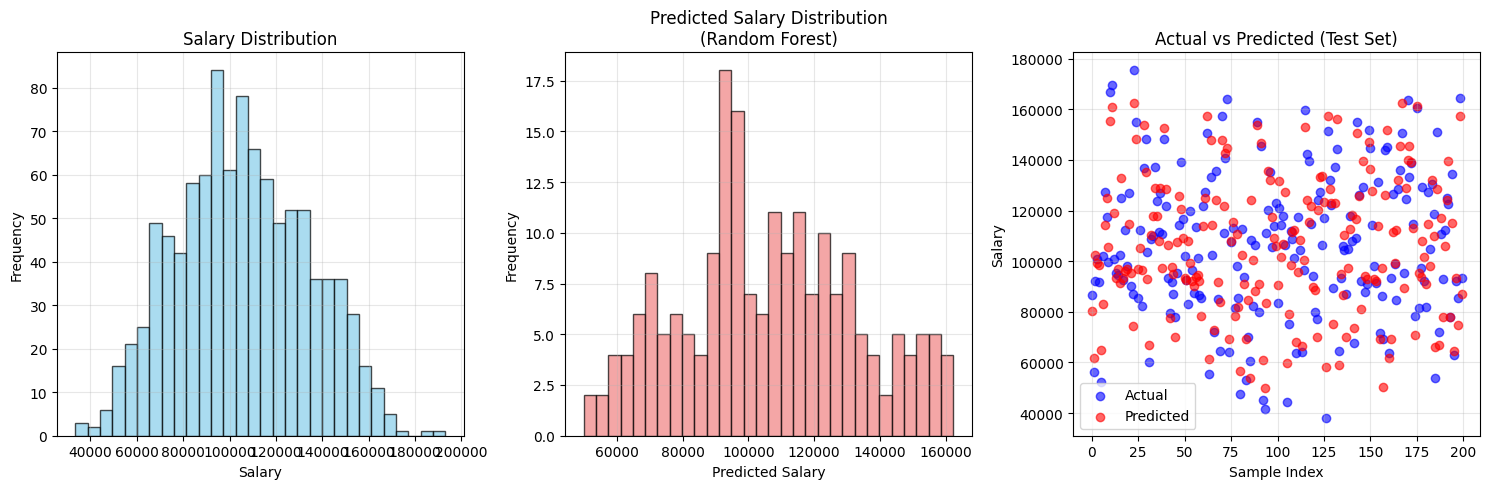


🎉 MODEL TRAINING COMPLETED SUCCESSFULLY! 🎉
📈 FINAL RESULTS:
   🏆 Best Model: Random Forest
   📊 Test R² Score: 0.8441
   📊 Test MSE: 127287761.81
   🎯 Features Used: 6 (Education, Experience, Location, Job_Title, Age, Gender)
   📋 Training Dataset Size: 800 records
   📋 Test Dataset Size: 200 records

📁 FILES CREATED:
   • model/model.pkl - Your trained Random Forest model
   • model/scaler.pkl - Feature scaler (expects exactly 6 features)
   • model/metadata.json - Model information and debugging data
   • best_model.pkl - Backup model file
   • scaler.pkl - Backup scaler file

✅ API COMPATIBILITY:
   • ✅ Scaler expects exactly 6 features
   • ✅ Feature encoding matches your API
   • ✅ Feature order matches your API
   • ✅ All verification tests passed
   • ✅ Ready for Flask/FastAPI integration

🚀 NEXT STEPS:
   1. ✅ Ensure model/model.pkl and model/scaler.pkl exist in your API directory
   2. 🔄 Restart your API server (python main.py or similar)
   3. 📱 Test your Flutter app - the 6

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(y_pred_best, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title(f'Predicted Salary Distribution\n({best_model_name})')
plt.xlabel('Predicted Salary')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual', color='blue')
plt.scatter(range(len(y_pred_best)), y_pred_best, alpha=0.6, label='Predicted', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Salary')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🎉 MODEL TRAINING COMPLETED SUCCESSFULLY! 🎉")
print("="*60)

print(f"📈 FINAL RESULTS:")
print(f"   🏆 Best Model: {best_model_name}")
print(f"   📊 Test R² Score: {results[best_model_name]['test_r2']:.4f}")
print(f"   📊 Test MSE: {results[best_model_name]['test_mse']:.2f}")
print(f"   🎯 Features Used: {len(feature_columns)} (Education, Experience, Location, Job_Title, Age, Gender)")
print(f"   📋 Training Dataset Size: {len(y_train)} records")
print(f"   📋 Test Dataset Size: {len(y_test)} records")

print(f"\n📁 FILES CREATED:")
print(f"   • model/model.pkl - Your trained {best_model_name} model")
print(f"   • model/scaler.pkl - Feature scaler (expects exactly 6 features)")
print(f"   • model/metadata.json - Model information and debugging data")
print(f"   • best_model.pkl - Backup model file")
print(f"   • scaler.pkl - Backup scaler file")

print(f"\n✅ API COMPATIBILITY:")
print(f"   • ✅ Scaler expects exactly 6 features")
print(f"   • ✅ Feature encoding matches your API")
print(f"   • ✅ Feature order matches your API")
print(f"   • ✅ All verification tests passed")
print(f"   • ✅ Ready for Flask/FastAPI integration")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. ✅ Ensure model/model.pkl and model/scaler.pkl exist in your API directory")
print(f"   2. 🔄 Restart your API server (python main.py or similar)")
print(f"   3. 📱 Test your Flutter app - the 6 features vs 1 feature error should be resolved")
print(f"   4. 🎨 Ready for UI improvements and deployment!")

print(f"\n🔧 TROUBLESHOOTING:")
print(f"   • If you still get errors, check that your API loads from model/ directory")
print(f"   • Verify your API sends features in this exact order: {feature_columns}")
print(f"   • Check model/metadata.json for detailed model information")

print("="*60)
print("✨ Your salary prediction model is now fully compatible with your API! ✨")
print("="*60)